In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## $\alpha$-chain

$\newcommand{\isotm}[2]{{}^{#2}\mathrm{#1}}$

We want to integrate a simple $\alpha$-network, consisting of $\isotm{He}{4}$, $\isotm{C}{12}$, $\isotm{O}{16}$, and $\isotm{Ne}{20}$, with the rates:
3-$\alpha$, followed by $\isotm{C}{12}(\alpha,\gamma)\isotm{O}{16}$ and $\isotm{O}{16}(\alpha,\gamma)\isotm{Ne}{20}$.



\begin{eqnarray*}
    \frac{dn_4}{dt} &=& -\frac{3n_4^3}{6} \langle 3\alpha \rangle -
                          n_4 n_{12} \langle \alpha 12 \rangle -
                          n_4 n_{16} \langle \alpha 16 \rangle \\
    \frac{dn_{12}}{dt} &=& \frac{n_4^3}{6} \langle 3\alpha \rangle -
                          n_4 n_{12} \langle \alpha 12 \rangle \\
    \frac{dn_{16}}{dt} &=& n_4 n_{12} \langle \alpha 12 \rangle -
                          n_4 n_{16} \langle \alpha 16 \rangle \\
    \frac{dn_{20}}{dt} &=& n_4 n_{16} \langle \alpha 16 \rangle 
\end{eqnarray*}

The rates (from CF88) are:

* $\langle 3\alpha \rangle = \langle \sigma v \rangle$ for the 3-$\alpha$ reaction.
  We can find this expressed as $N_A^2 \langle \sigma v \rangle_{\alpha\alpha\alpha}$:

  \begin{equation}
        N_A^2 \langle \sigma v \rangle_{\alpha\alpha\alpha} = \frac{2.79\times 10^{-8}}{T_9^3} \exp(-4.4027/T_9)
  \end{equation}

* $\langle \alpha 12 \rangle =  \langle \sigma v \rangle$ for the
  $\isotm{C}{12}(\alpha,\gamma)\isotm{O}{16}$ reaction.  We find this expressed
  as $N_A \langle \sigma v \rangle_{C\alpha}$:

  \begin{eqnarray*}
        N_A \langle \sigma v \rangle_{C\alpha} = &&
           \frac{1.04\times 10^8}{T_9^2 (1.0 + 0.0489/T_9^{2/3})^2} 
              \exp(-32.120/T_9^{1/3} - (T_9/3.496)^2) + \nonumber \\
              && \frac{1.76\times 10^8}{T_9^2 (1.0+0.2654/T_9^{2/3})^2} 
                \exp(-32.120/T_9^{1/3}) + \nonumber \\
                &&\frac{1.25\times 10^3}{T_9^{3/2}} \exp(-27.499/T_9) +
                1.43\times 10^{-2} T_9^5 \exp(-15.541/T_9)
  \end{eqnarray*}

*  $\langle \alpha 16 \rangle =  \langle \sigma \ v \rangle$ for the
   $\isotm{O}{16}(\alpha,\gamma)\isotm{Ne}{20}$ reaction.  We find this expressed
   as $N_A \langle \sigma v \rangle_{O\alpha}$:

  \begin{eqnarray*}
        N_A \langle \sigma v \rangle_{O\alpha} = &&
        \frac{9.37\times 10^9}{T_9^{2/3}} \exp(-39.757/T_9^{1/3}-(T_9/1.586)^2) + \nonumber \\
                 && \frac{6.21\times 10^1}{T_9^{3/2}} \exp(-10.297/T_9) + \nonumber \\
                 && \frac{5.38\times 10^2}{T_9^{3/2}} \exp(-12.226/T_9) + \nonumber \\
                 && 1.30\times 10^1 T_9^2 \exp(-20.093/T_9)
  \end{eqnarray*}



## Number density to mass / molar fractions

As written our system is expressed in terms of number density.  Recall:

$$n_k = \frac{\rho X_k}{m_u A_k} = \frac{\rho Y_k}{m_u}$$

or using $N_A = 1/m_u$, we have:

$$n_k = \frac{\rho N_A X_k}{A_k} = \rho N_A Y_k$$

We'll work in terms of mass fractions, which have the property that

$$\sum_k X_k = 1$$

For example, to rewrite the evolution equation for $\isotm{He}{4}$, we could have:

$$\frac{N_A\rho}{A_4} \frac{dX_4}{dt} = -\frac{1}{2} \left ( \frac{N_A \rho X_4}{A_4} \right )^3  \langle 3\alpha \rangle -
                          \left (\frac{N_A\rho X_4}{A_4} \right ) \left ( \frac{N_A\rho X_{12}}{A_{12}} \right ) \langle \alpha 12 \rangle -
                          \left ( \frac{N_A\rho  X_4}{A_4} \right ) \left (\frac{N_A\rho X_{16}}{A_{16}} \right ) \langle \alpha 16 \rangle$$
                          
or simplifying:

$$\frac{dX_4}{dt} = -\frac{1}{2} \frac{\rho^2}{A_4^2} X_4^3 N_A^2  \langle 3\alpha \rangle -
                          \frac{\rho}{A_{12}} X_4 X_{12} N_A \langle \alpha 12 \rangle -
                          \frac{\rho}{A_{16}} X_4 X_{16} N_A \langle \alpha 16 \rangle$$

Note how $N_A$ enters with the rate is consistent with the expressions we were given above.

Now we can write our RHS function in terms of mass fractions:

In [2]:
def rhs(t, X, rho, T):

    X4  = X[0]
    X12 = X[1]
    X16 = X[2]
    X20 = X[3]

    # temperature factors
    T9 = T/1.e9
    T913 = T9**(1./3.)
    T923 = T913**2
    T932 = T9**1.5

    # N_A**2 <sigma v> for 3-alpha from CF88 for T9 > 0.08
    r3a = 2.79e-8/T9**3 * np.exp(-4.4027/T9)

    # N_A <sigma v> for C12(a,g)O16
    rc12ago16 = 1.04e8/T9**2/(1.0 + 0.0489/T923)**2 * \
                np.exp(-32.120/T913-(T9/3.496)**2)+1.76e8/T9**2/(1.0+0.2654/T923)**2 * \
                np.exp(-32.120/T913) + 1.25e3/T932*np.exp(-27.499/T9) + \
                1.43e-2*T9**5 * np.exp(-15.541/T9)

    # N_A <sigma v> for O16(a,g)Ne20
    ro16agne20 = 9.37e9/T923*np.exp(-39.757/T913-(T9/1.586)**2) + \
                 6.21e1/T932*np.exp(-10.297/T9)+5.38e2/T932*np.exp(-12.226/T9) + \
                 1.30e1*T9**2*np.exp(-20.093/T9)


    dX4dt = -(1./32.)*rho**2*X4**3*r3a - (1./12.)*rho*X4*X12*rc12ago16 - (1./16.)*rho*X4*X16*ro16agne20
    dX12dt = (1./32.)*rho**2*X4**3*r3a - 0.25*rho*X4*X12*rc12ago16
    dX16dt = (1./3.)*rho*X4*X12*rc12ago16 - 0.25*rho*X4*X16*ro16agne20
    dX20dt = (5./16.)*rho*X4*X16*ro16agne20

    return np.array([dX4dt, dX12dt, dX16dt, dX20dt])

We can already investigate timescales for the burning&mdash;consider starting off with pure He, the timescale to consume the helium is:

$$\tau_\mathrm{burn} \sim \frac{X_0(\isotm{He}{4})}{|dX(\isotm{He}{4})/dt|}$$

Let's plot this for $\rho = 10^4~\mathrm{g~cm^{-3}}$ as a function of temperature

Text(0, 0.5, '$\\tau$')

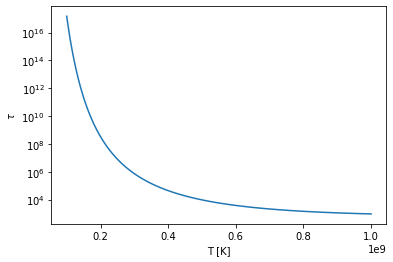

In [3]:
fig, ax = plt.subplots()

rho = 1.e4
X = np.array([1.0, 0.0, 0.0, 0.0])
T = np.logspace(8., 9, 100)

tau = []
for TT in T:
    dXdt = rhs(0.0, X, rho, TT)
    tau.append(X[0]/np.abs(dXdt[0]))

ax.semilogy(T, tau)
ax.set_xlabel("T [K]")
ax.set_ylabel(r"$\tau$")

Note how strong the temperature dependence is.  At the low end, $\log_{10} T = 8.2$, the timescale to burn is $\sim 10^{11}$ s, while at the high end, it is $\sim 10^3$ s.

Note that this is only an estimate&mdash;once we make C and O, more He will be consumed, further shortening this timescale.

Now we can integrate the system.  We'll use the SciPy `solve_ivp` function.  Note that this network is stiff, so we will use the `"BDF"` method.

In [4]:
def integrate(t_end, X0, rho, T):

    sol = solve_ivp(rhs, [0, tmax], X0, method="BDF",
                    dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

    return sol.t, sol.y

Let's integrate!

In [5]:
def plot(t_out, X_out):
    fig, ax = plt.subplots()

    ax.plot(t_out / year, X_out[0,:], label="He4")
    ax.plot(t_out / year, X_out[1,:], label="C12")
    ax.plot(t_out / year, X_out[2,:], label="O16")
    ax.plot(t_out / year, X_out[3,:], label="Ne20")

    ax.legend(frameon=False, loc="best")
    ax.set_ylim(1.e-11, 2)
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    fig.set_size_inches(8,6)
    return fig

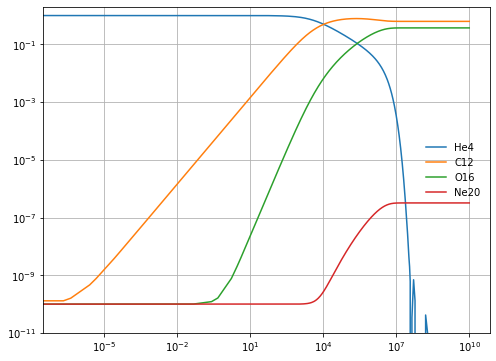

In [6]:
X0 = np.array([1.0, 1.e-10, 1.e-10, 1.e-10])

rho = 1.e4
T = 1.5e8

year = 3.16e7
tmax = 1.e10 * year

t_out, X_out = integrate(tmax, X0, rho, T)

fig = plot(t_out, X_out)

Notice that as He is consumed, initially we build up C, but once there is enough C, we start to make O and then a little Ne.

What happens at higher T?

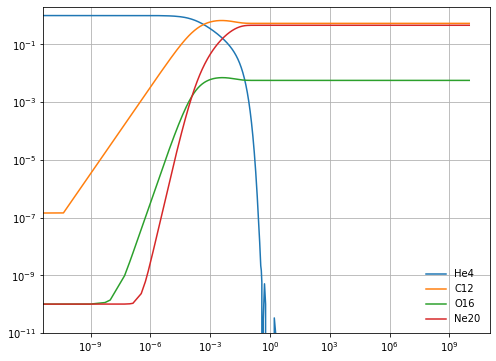

In [7]:
rho = 1.e4
T = 5.e8

year = 3.16e7
tmax = 1.e10 * year

t_out, X_out = integrate(tmax, X0, rho, T)

fig = plot(t_out, X_out)

Now we burn much faster (as expected), but also make a lot of Ne!

Now even hotter...

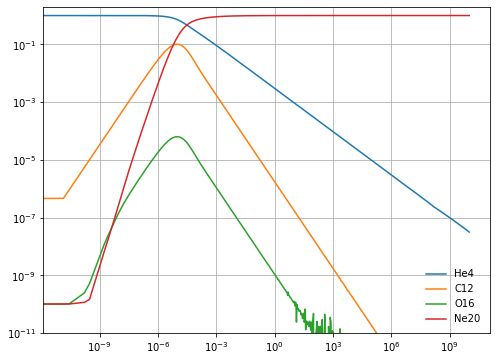

In [8]:
rho = 1.e4
T = 1.e9

year = 3.16e7
tmax = 1.e10 * year

t_out, X_out = integrate(tmax, X0, rho, T)

fig = plot(t_out, X_out)

Here everything goes to Ne very quickly!

What did we leave out?

* screening: at high density, the rates will be even higher due to electron screening 

* T evolution: as we burn, we dump energy into the star, so it should be getting hotter, which makes the rates go faster.  But we are not capturing that.